# Lab 6 - Convolutional Neural Networks
by Rebecca Kuhlman, Sam Yao, and Michael Amberg



Business Understanding
Identifying the type of brain tumor a patient has is an important step in figuring out the treatment plan of a patient. They can be diagnosed via MRI imaging, leading to interest in using machine learning to diagnose the patient. Having a second opinion on brain tumor diagnoses would help improve patient care and outcomes, and lessen stress on doctors. A machine learning model could also speed up analysis time and pick out which patients are in need of urgent treatment.
In this dataset, there is glioma, meningioma, and pituitary tumors, as well as MRI images with no tumors. Glioma tumors are usually malignant, while meningioma and pituitary tumors are usually benign. Different types of tumors are made of different types of cells and have a location where they are most likely to be located. More information can be found at: https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084
There are many other types of tumors that future algorithms will be need to address. The majority of other types of tumors are more common in children, while the set we are dealing with are all adult brain images.
Because the model deals with health conditions that have extreme affects on the patient, model accuracy is extremely important. Furthermore, accuracy must fine-tuned to avoid fatal misdiagnosis. While incorrectly marking a patient with a benign tumor as malignant is wasteful, the adverse affects are minimal. Inversely, misdiagnosing a malignant tumor as benign may have fatal effects for the patient. Therefore, the designed model must minimize the rate of false negatives with accuracy of 95% or more.
It should be noted that the majority of misdiagnose of brain tumors happen before a brain scan or related test is ordered. https://paulandperkins.com/brain-tumors/

## Preparation

[1.5 points] 
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

Because we will be dealing with identifying brain tumors, we want to use Recall. The equation for Recall takes into account False Negatives, which would be very bad if you falsely cleared someone of brain tumors, but they did in fact have a tumor. This will be a high stakes identification, so at the very least our recall score should be 85% accuarate to be deployed.

[1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

We could try Stratified 10 k-fold validation, because it seemed to be effective from the results we had in the last lab. I have no idea if this would extend to image data, but we could give it a try.
Stratified 10 k-fold validation is most effective with small amounts of imbalanced data. We have to think about balance a lot in our data as our tumor categories will have differing likelihoods, and we have a lot of different types of MRI photos.
In a deployment setting, different tumors (or when we are actually getting a tumor) will come up at different rates. There are many types of tumors with different subcategories, we will only be training our program for 3 types of brain tumors. Our program must be robust under these uneven circumstances. Stratified 10 k-fold validation would be one way to address this.

- https://www.analyseup.com/python-machine-learning/stratified-kfold.html
- https://www.aans.org/en/Patients/Neurosurgical-Conditions-and-Treatments/Brain-Tumors

## Modeling

[1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/ Links to an external site.)

In [63]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import struct

# This method creates the data, whether training or testing, in the form we desire
# Reused code from Lab 2
def create_dataset(img_folder):
    # Read through all files in "img_folder"
    img_data_array = []
    class_name = []
    
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            img = cv2.imread(os.path.join(img_folder,dir1,file))
            img = cv2.resize(img,(256, 256)) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)         #Images are in grayscale anyway, may as well make it official
            img_normalized = cv2.normalize(img,None,0,1.0,
                                           cv2.NORM_MINMAX, 
                                           dtype=cv2.CV_32F)
            img_data_array.append([img_normalized])             #Image bracketed to ensure that each image shows one channel
            class_name.append(dir1)
    
    # return array with training data.
    img_data_array = np.array(img_data_array)
    class_name = np.array(class_name)
    return img_data_array, class_name

Our data process reads all the images, resizes them to (256, 256) pixels, converts them to grayscale, and normalizes the pixel values. By doing this, we reduce each image's size, thus substantially decreasing the complexity for training our model. Because the images are greyscale already, we can set each image to greyscale using cv2 and reduce the vectors needed to represent color from 3 (rgb) to 1. This further simplifies the data and speeds up processing time for the model. 

In [89]:
#Load the training and testing datasets
df_training, training_classes = create_dataset("./Training")
df_testing, testing_classes = create_dataset("./Testing")

#Reshape the training and testing datasets
df_training = df_training.reshape((df_training.shape[0], 256, 256, 1))
df_testing = df_testing.reshape((df_testing.shape[0], 256, 256, 1))

In [3]:
np.unique(training_classes)

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

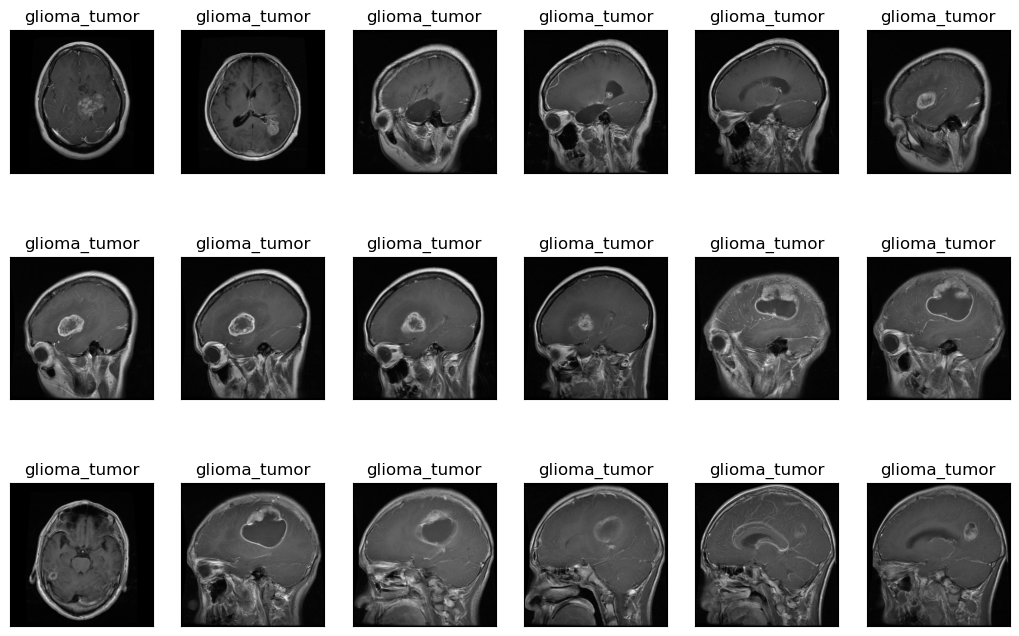

In [4]:
import random

# Helper Function to plot pictures
# Taken from Dr. Larson's Notebook
# Modified to show random images of tumors and their categories
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    
    #r = random.randint(0,(2870 - (n_row * n_col))) #This part was added to randomly show tumor pics
    
    
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+ 1)
        
        # Random dist. added here
        plt.imshow(images[i].reshape((h, w)).astype('float'), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        
        plt.xticks(())
        plt.yticks(())
plot_gallery(df_training, training_classes, 256, 256, 3, 6) # defaults to showing a 3 by 6 subset of the faces

As we can see, despite the complexity of each image being reduced, they are still quite clear and distinct from one another.

### Data Augmentation

[1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10, # used, Int. Degree range for random rotations.
    width_shift_range=0.15, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.15, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0.05, # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.1, # Float. Zoom intensity could be 
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(df_training)

2023-05-02 20:25:46.621239: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Above are the settings for Data Augmentation. To list them out nicely:
- Rotation Range: 10 degrees
- Width/Height Shift Range: 15% 
- Shear: 5%
- Zoom: 10%
- Horizontal Flip: No
- Vertical Flip: No

Rotation Range and Width/Height Shift Range: We chose 10 degrees and 25% respectively because not all heads and brains are shaped the same, so it's possible that there could be some slight variation in this area. Thus it is best to take this into account.

Shear: Again, this is done for good measure (at only 5%) to account for variation in brain and head shapes and sizes.

Zoom: Set at 10% to account for variation in brain and head shapes/sizes.

Horizontal/Vertical Flip:In most of the training data and in various brain scans found online, the MRI is taken on the left side of the person's head, so we assume that MRI's are typically taken this way. Of course, this could be a faulty assumption, as none of us have extensive experience or domain knowledge with brain scans. 


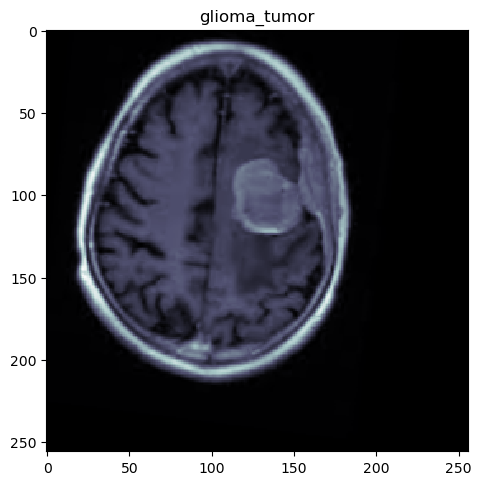

In [6]:
import matplotlib.pyplot as plt
from skimage.io import imshow
tmps = datagen.flow(df_training, training_classes, batch_size=1)
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for tmp in tmps:
     imshow(tmp[0].squeeze(),cmap='bone')
     plt.title(labels[np.argmax(tmp[1])])
     break

Seen in the image above, the clarity and sharpness of the image are reduced as a result of our resizing each image to 256x256. However, the edges are still clear within the pictures which makes structures or objects within the image clear to identify.

In [5]:
#Change target classes to be integer so they can be used in OHE:
'glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'
for i in range(len(training_classes)):
    if training_classes[i] == 'glioma_tumor':
        training_classes[i] = int(1)
    elif training_classes[i] == 'meningioma_tumor':
        training_classes[i] = int(2)
    elif training_classes[i] == 'pituitary_tumor':
        training_classes[i] = int(3)
    else:
        training_classes[i] = int(0)

for i in range(len(testing_classes)):
    if testing_classes[i] == 'glioma_tumor':
        testing_classes[i] = int(1)
    elif testing_classes[i] == 'meningioma_tumor':
        testing_classes[i] = int(2)
    elif testing_classes[i] == 'pituitary_tumor':
        testing_classes[i] = int(3)
    else:
        testing_classes[i] = int(0)

In [11]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
NUM_CLASSES = 4

#One Hot Encode the target variables
y_train_ohe = keras.utils.to_categorical(training_classes, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(testing_classes, NUM_CLASSES)

In [12]:
# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30,
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mse',
              optimizer='rmsprop',
              metrics=[tf.keras.metrics.Recall()])

%time mlp_history = mlp.fit(df_training, y_train_ohe, validation_split = 0.2, batch_size=32, epochs=150, shuffle=True, verbose=0)

CPU times: user 2min 29s, sys: 1min 37s, total: 4min 7s
Wall time: 44.8 s


dict_keys(['loss', 'recall_1', 'val_loss', 'val_recall_1'])


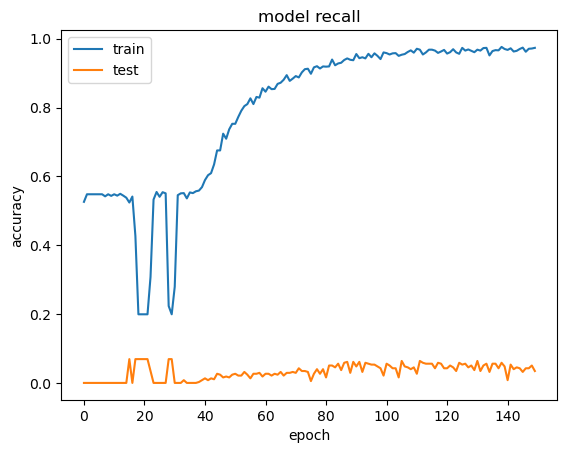

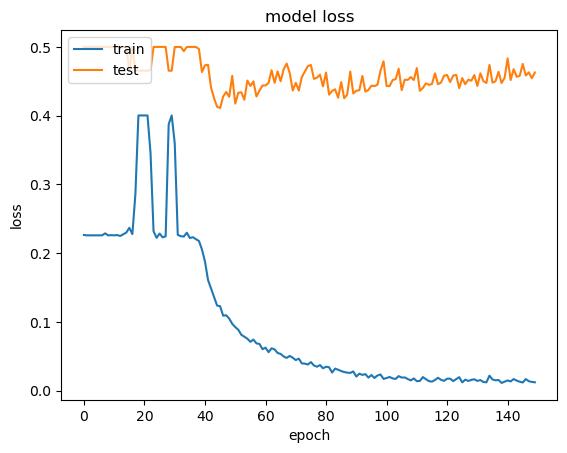

In [14]:
# list all data in history
print(mlp_history.history.keys())
# summarize history for accuracy
plt.plot(mlp_history.history['recall_1'])
plt.plot(mlp_history.history['val_recall_1'])
plt.title('model recall')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The 3 layer MLP model fails to converge

### The following code is to save and load models efficiently
<hr>
<hr>
<hr>

In [48]:
mlp.save('my_little_perceptron.keras',overwrite=True,save_format="keras")

In [49]:
model = keras.models.load_model("my_little_perceptron.keras")

<hr>
<hr>
<hr>

[2 points]Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge.

### CNN Architecture 1:

In [15]:
# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same',
                input_shape=(256,256,1),
               ) )

cnn.add( MaxPooling2D(pool_size=(2, 2)) )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 1048580   
_________________________________________________________________
activation_3 (Activation)    (None, 4)                 0         
Total params: 1,048,660
Trainable params: 1,048,660
Non-trainable params: 0
____________________________________________

In [25]:
cnn.compile(loss='mse',
              optimizer='rmsprop',
              metrics=[tf.keras.metrics.Recall()])
#cnn.fit(df_training, y_train_ohe,epochs=150, verbose= 0)
cnn_history = cnn.fit(datagen.flow(df_training, y_train_ohe, batch_size=32),
        steps_per_epoch=int(len(df_training)/32),
                      validation_data=(df_testing,y_test_ohe),
                    epochs=50, verbose= 1)

Epoch 1/50
58/58 [==============================] - 12s 188ms/step - loss: 0.2825 - recall_9: 0.4349 - val_loss: 0.3541 - val_recall_9: 0.2919
Epoch 2/50
58/58 [==============================] - 11s 183ms/step - loss: 0.2784 - recall_9: 0.4431 - val_loss: 0.3541 - val_recall_9: 0.2919
Epoch 3/50
58/58 [==============================] - 11s 182ms/step - loss: 0.2884 - recall_9: 0.4232 - val_loss: 0.3541 - val_recall_9: 0.2919
Epoch 4/50
58/58 [==============================] - 11s 188ms/step - loss: 0.2769 - recall_9: 0.4462 - val_loss: 0.3541 - val_recall_9: 0.2919
Epoch 5/50
58/58 [==============================] - 11s 183ms/step - loss: 0.2850 - recall_9: 0.4299 - val_loss: 0.3541 - val_recall_9: 0.2919
Epoch 6/50
58/58 [==============================] - 11s 185ms/step - loss: 0.2785 - recall_9: 0.4430 - val_loss: 0.3541 - val_recall_9: 0.2919
Epoch 7/50
58/58 [==============================] - 11s 184ms/step - loss: 0.2775 - recall_9: 0.4396 - val_loss: 0.3311 - val_recall_9: 0.3198

dict_keys(['loss', 'recall_9', 'val_loss', 'val_recall_9'])


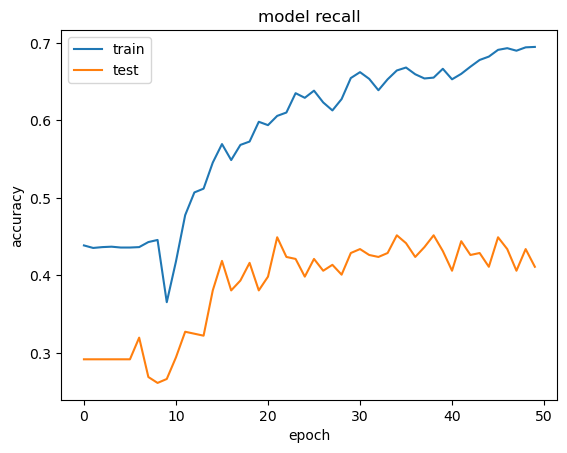

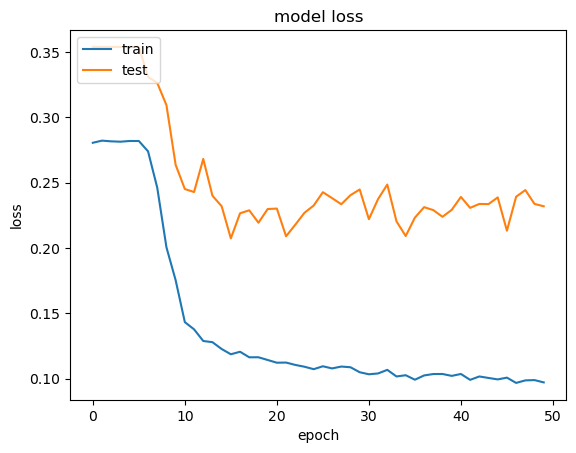

In [26]:
# list all data in history
print(cnn_history.history.keys())
# summarize history for accuracy
plt.plot(cnn_history.history['recall_9'])
plt.plot(cnn_history.history['val_recall_9'])
plt.title('model recall')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
cnn.save('CNN_1.keras',overwrite=True,save_format="keras")

### CNN Architecture 2:

In [27]:
cnn2 = Sequential()
cnn2.add( Conv2D(filters=32, kernel_size= (3, 3), padding='same',input_shape=(256,256,1),))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Conv2D(filters=64, kernel_size= (3, 3), padding='same',input_shape=(256,256,1),))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Activation('relu'))
cnn2.add(Flatten())
cnn2.add(Dense(NUM_CLASSES))
cnn2.add(Activation('softmax'))

cnn2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                

In [28]:
cnn2.compile(loss='mse',
              optimizer='rmsprop',
              metrics=[tf.keras.metrics.Recall()])
cnn2_history = cnn2.fit(datagen.flow(df_training, y_train_ohe, batch_size=32),
        steps_per_epoch=int(len(df_training)/32),
        validation_data=(df_testing, y_test_ohe),
        epochs=50, verbose= 1)

Epoch 1/50
58/58 [==============================] - 18s 255ms/step - loss: 0.2178 - recall_10: 0.2956 - val_loss: 0.2073 - val_recall_10: 0.0558
Epoch 2/50
58/58 [==============================] - 11s 184ms/step - loss: 0.1544 - recall_10: 0.3095 - val_loss: 0.2092 - val_recall_10: 0.1827
Epoch 3/50
58/58 [==============================] - 11s 184ms/step - loss: 0.1483 - recall_10: 0.3138 - val_loss: 0.2425 - val_recall_10: 0.3274
Epoch 4/50
58/58 [==============================] - 11s 181ms/step - loss: 0.1392 - recall_10: 0.4085 - val_loss: 0.2446 - val_recall_10: 0.2893
Epoch 5/50
58/58 [==============================] - 11s 183ms/step - loss: 0.1323 - recall_10: 0.4785 - val_loss: 0.2661 - val_recall_10: 0.3223
Epoch 6/50
58/58 [==============================] - 11s 182ms/step - loss: 0.1322 - recall_10: 0.4832 - val_loss: 0.2254 - val_recall_10: 0.2995
Epoch 7/50
58/58 [==============================] - 11s 182ms/step - loss: 0.1216 - recall_10: 0.5283 - val_loss: 0.2220 - val_rec

dict_keys(['loss', 'recall_10', 'val_loss', 'val_recall_10'])


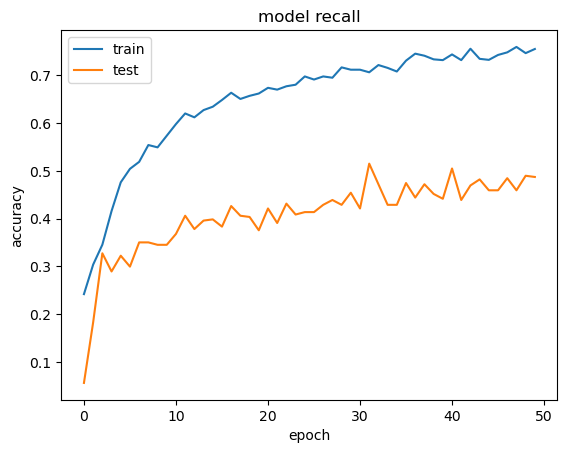

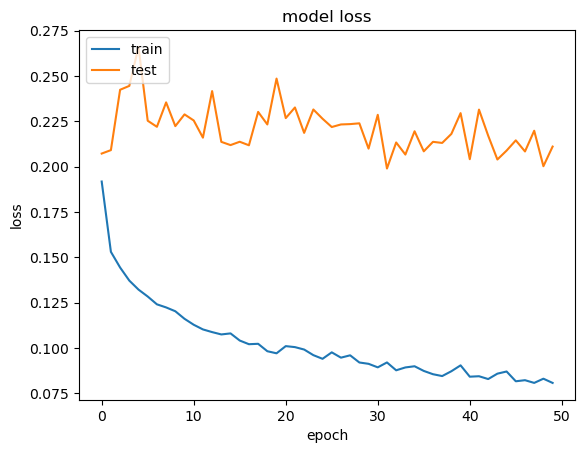

In [29]:
# list all data in history
print(cnn2_history.history.keys())
# summarize history for accuracy
plt.plot(cnn2_history.history['recall_10'])
plt.plot(cnn2_history.history['val_recall_10'])
plt.title('model recall')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn2_history.history['loss'])
plt.plot(cnn2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
cnn2.save('CNN_2.keras',overwrite=True,save_format="keras")

### Variation on CNN_1

Changed to have 64 filters in the Convolution layer, as well as a kernel size of 5x5

In [30]:
# make a CNN with conv layer and max pooling
cnn_1_mk_2 = Sequential()
cnn_1_mk_2.add( Conv2D(filters=64, kernel_size= (5, 5), padding='same',
                input_shape=(256,256,1),
               ) )

cnn_1_mk_2.add( MaxPooling2D(pool_size=(2, 2)) )
cnn_1_mk_2.add( Activation('relu') )
# add one layer on flattened output
cnn_1_mk_2.add( Flatten() )
cnn_1_mk_2.add( Dense(NUM_CLASSES) )
cnn_1_mk_2.add( Activation('softmax') )

cnn_1_mk_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 64)      1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
activation_6 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1048576)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 4194308   
_________________________________________________________________
activation_7 (Activation)    (None, 4)                 0         
Total params: 4,195,972
Trainable params: 4,195,972
Non-trainable params: 0
____________________________________________

In [31]:
cnn_1_mk_2.compile(loss='mse',
              optimizer='rmsprop',
              metrics=[tf.keras.metrics.Recall()])
cnn_1_mk_1_history = cnn_1_mk_2.fit(datagen.flow(df_training, y_train_ohe, batch_size=32),
        steps_per_epoch=int(len(df_training)/32),
        validation_data=(df_testing, y_test_ohe),
        epochs=50, verbose= 1)

Epoch 1/50
58/58 [==============================] - 14s 212ms/step - loss: 0.2720 - recall_11: 0.4043 - val_loss: 0.3541 - val_recall_11: 0.2919
Epoch 2/50
58/58 [==============================] - 11s 186ms/step - loss: 0.2756 - recall_11: 0.4487 - val_loss: 0.3541 - val_recall_11: 0.2919
Epoch 3/50
58/58 [==============================] - 11s 186ms/step - loss: 0.2747 - recall_11: 0.4506 - val_loss: 0.3541 - val_recall_11: 0.2919
Epoch 4/50
58/58 [==============================] - 11s 183ms/step - loss: 0.2842 - recall_11: 0.4317 - val_loss: 0.3541 - val_recall_11: 0.2919
Epoch 5/50
58/58 [==============================] - 11s 185ms/step - loss: 0.2805 - recall_11: 0.4391 - val_loss: 0.3541 - val_recall_11: 0.2919
Epoch 6/50
58/58 [==============================] - 11s 187ms/step - loss: 0.2785 - recall_11: 0.4430 - val_loss: 0.3541 - val_recall_11: 0.2919
Epoch 7/50
58/58 [==============================] - 11s 185ms/step - loss: 0.2850 - recall_11: 0.4300 - val_loss: 0.3541 - val_rec

dict_keys(['loss', 'recall_11', 'val_loss', 'val_recall_11'])


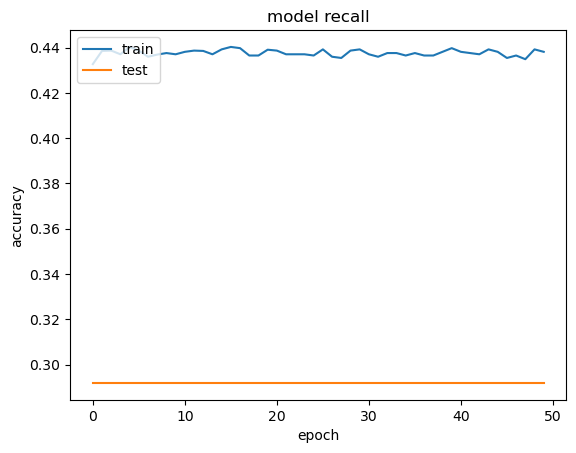

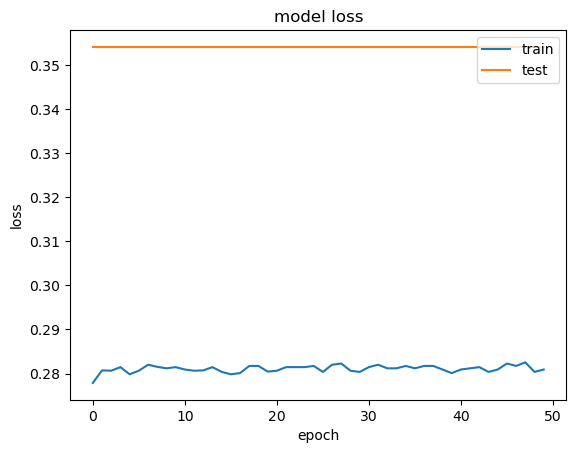

In [32]:
# list all data in history
print(cnn_1_mk_1_history.history.keys())
# summarize history for accuracy
plt.plot(cnn_1_mk_1_history.history['recall_11'])
plt.plot(cnn_1_mk_1_history.history['val_recall_11'])
plt.title('model recall')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn_1_mk_1_history.history['loss'])
plt.plot(cnn_1_mk_1_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Variation on CNN_2

In [33]:
cnn2_mk2 = Sequential()
cnn2_mk2.add( Conv2D(filters=64, kernel_size= (3, 3), padding='same',input_shape=(256,256,1),))
cnn2_mk2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2_mk2.add(Conv2D(filters=128, kernel_size= (3, 3), padding='same',input_shape=(256,256,1),))
cnn2_mk2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2_mk2.add(Activation('relu'))
cnn2_mk2.add(Flatten())
cnn2_mk2.add(Dense(NUM_CLASSES))
cnn2_mk2.add(Activation('softmax'))

cnn2_mk2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
activation_8 (Activation)    (None, 64, 64, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 524288)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

In [36]:
cnn2_mk2.compile(loss='mse',
              optimizer='rmsprop',
              metrics=[tf.keras.metrics.Recall()])
cnn2_mk2_history = cnn2_mk2.fit(datagen.flow(df_training, y_train_ohe, batch_size=32),
        steps_per_epoch=int(len(df_training)/32),
        validation_data=(df_testing, y_test_ohe),
        epochs=50, verbose= 1)

Epoch 1/50
58/58 [==============================] - 13s 210ms/step - loss: 0.2220 - recall_14: 0.3149 - val_loss: 0.2019 - val_recall_14: 0.1548
Epoch 2/50
58/58 [==============================] - 11s 184ms/step - loss: 0.1581 - recall_14: 0.2306 - val_loss: 0.2121 - val_recall_14: 0.2970
Epoch 3/50
58/58 [==============================] - 11s 187ms/step - loss: 0.1436 - recall_14: 0.3738 - val_loss: 0.2294 - val_recall_14: 0.2081
Epoch 4/50
58/58 [==============================] - 11s 186ms/step - loss: 0.1392 - recall_14: 0.4495 - val_loss: 0.2334 - val_recall_14: 0.3553
Epoch 5/50
58/58 [==============================] - 11s 188ms/step - loss: 0.1324 - recall_14: 0.4810 - val_loss: 0.2403 - val_recall_14: 0.3350
Epoch 6/50
58/58 [==============================] - 11s 184ms/step - loss: 0.1278 - recall_14: 0.5056 - val_loss: 0.2291 - val_recall_14: 0.3553
Epoch 7/50
58/58 [==============================] - 11s 183ms/step - loss: 0.1203 - recall_14: 0.5578 - val_loss: 0.2386 - val_rec

dict_keys(['loss', 'recall_14', 'val_loss', 'val_recall_14'])


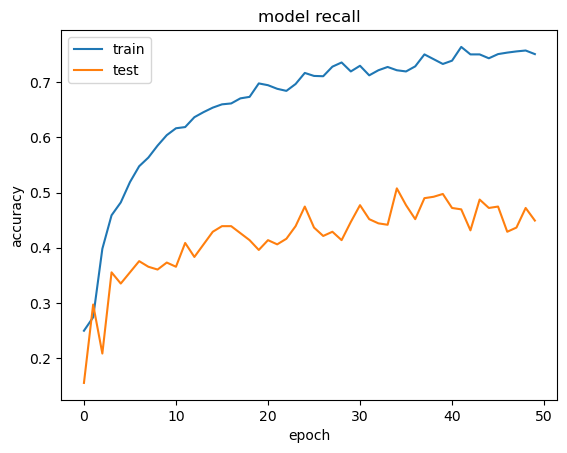

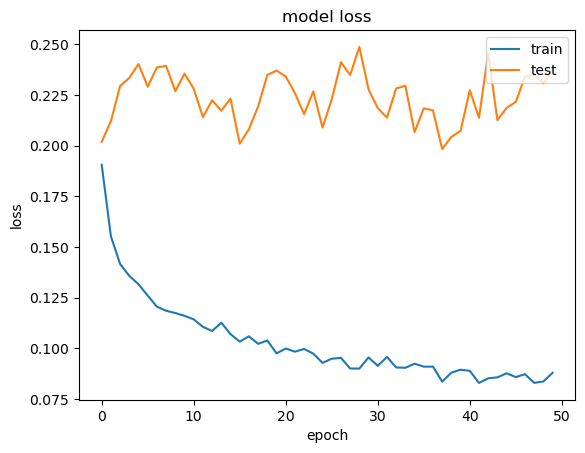

In [37]:
# list all data in history
print(cnn2_mk2_history.history.keys())
# summarize history for accuracy
plt.plot(cnn2_mk2_history.history['recall_14'])
plt.plot(cnn2_mk2_history.history['val_recall_14'])
plt.title('model recall')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn2_mk2_history.history['loss'])
plt.plot(cnn2_mk2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [45]:
y_test = testing_classes.astype(dtype='i')

In [49]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.recall_score(y_test,yhat_cnn, average = 'micro')
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))

    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.recall_score(y_test,yhat_mlp, average = 'micro')
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))

### Comparing CNN 1 vs. MLP

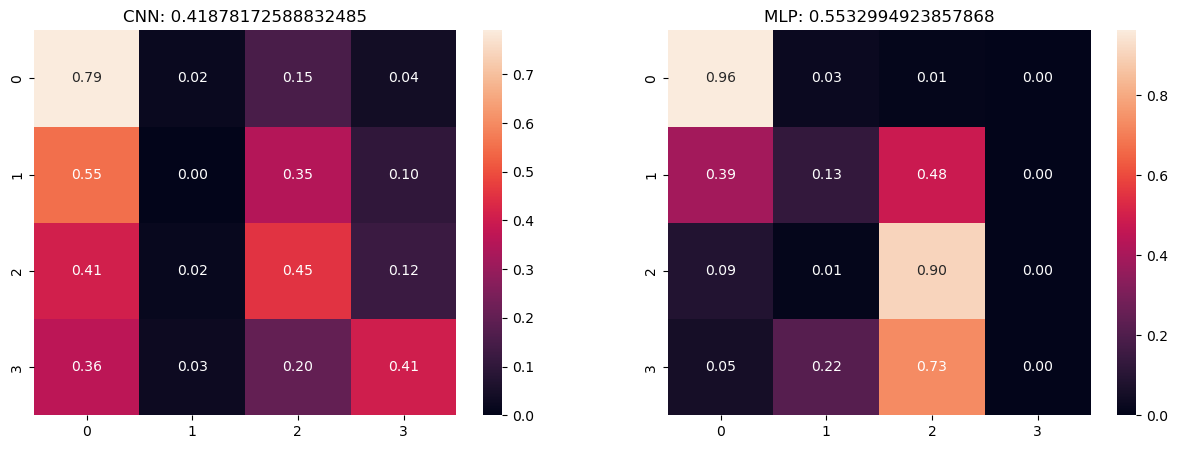

In [50]:
compare_mlp_cnn(cnn,mlp,df_testing,y_test)

### Comparing CNN 2 vs MLP

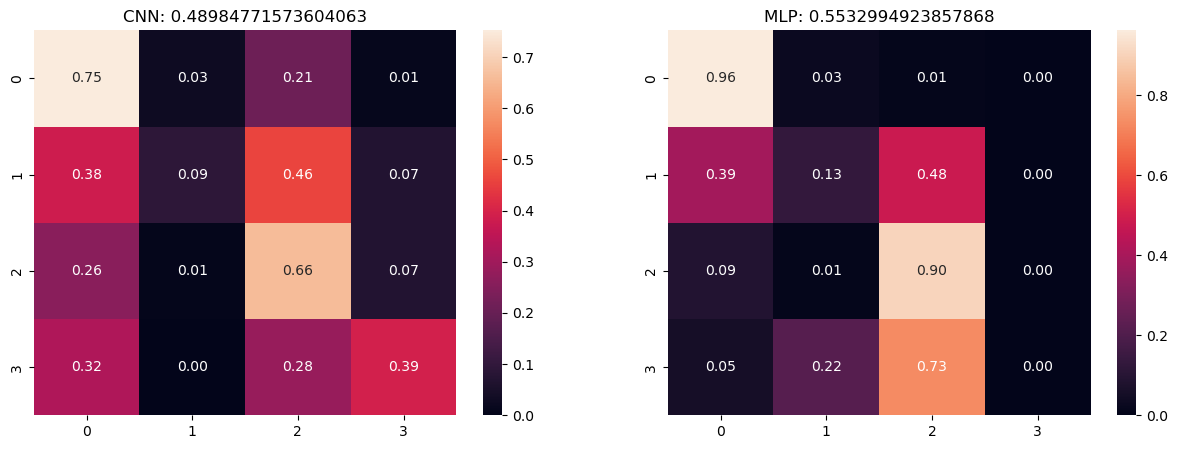

In [51]:
compare_mlp_cnn(cnn2,mlp,df_testing,y_test)

### CNN1 Mk1 vs MLP

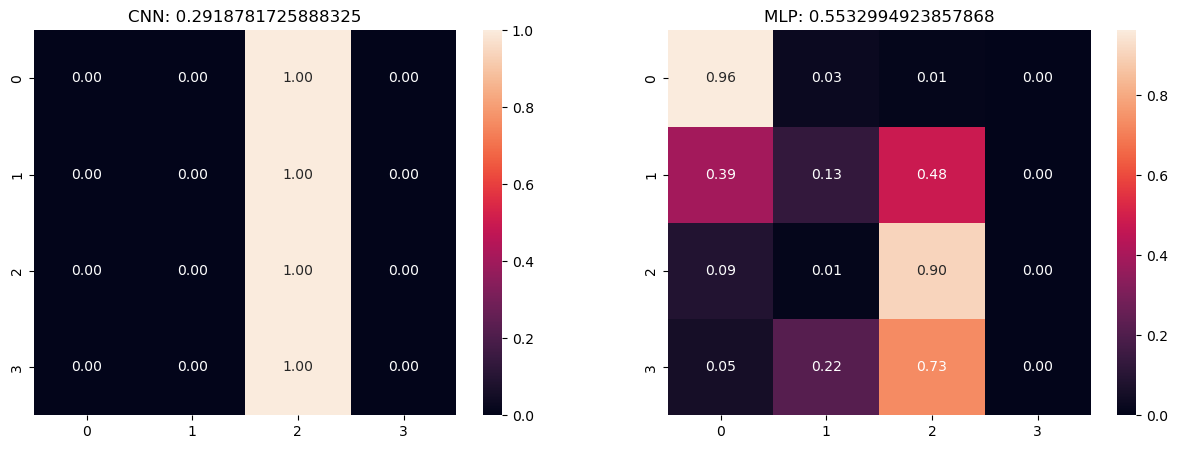

In [52]:
compare_mlp_cnn(cnn_1_mk_2,mlp,df_testing,y_test)

### CNN 2 Mk 2 vs MLP

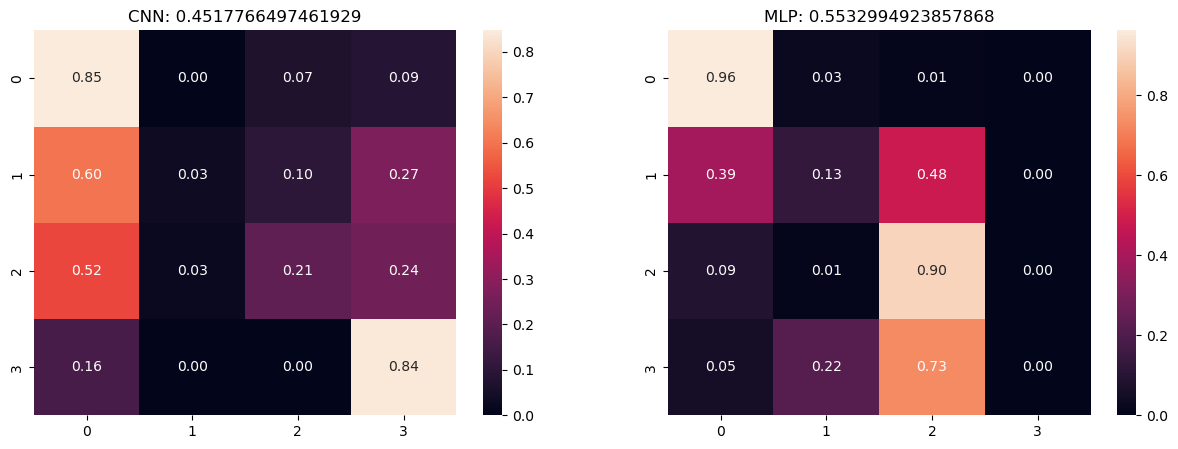

In [53]:
compare_mlp_cnn(cnn2_mk2,mlp,df_testing,y_test)

For both models and their variations, we find that while the training set is able to improve over time to minimize loss/recall, the model fails to converge when using test data. It appears that there are dramatic shifts in the training data as the epochs progress, with sharp increases or decreases rather than a steady rate of change towards the training model, suggesting that the model is overfitting to the training data and causing the accuracy to fluctuate irregularly. 

## Plotting ROC Curves

In [87]:
# Function to generate the ROC curve of all the models for comparison
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from numpy import interp
from itertools import cycle

def plot_roc_curve(model, X_test, y_test):
    lb = LabelBinarizer()
    y_test = lb.fit_transform(y_test)
    y_score = model.predict(X_test)
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves for each class and the macro-averaged curve
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot(fpr["macro"], tpr["macro"], color='navy', lw=2,
             label='Macro-average ROC curve (AUC = {0:0.2f})'
             ''.format(roc_auc["macro"]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

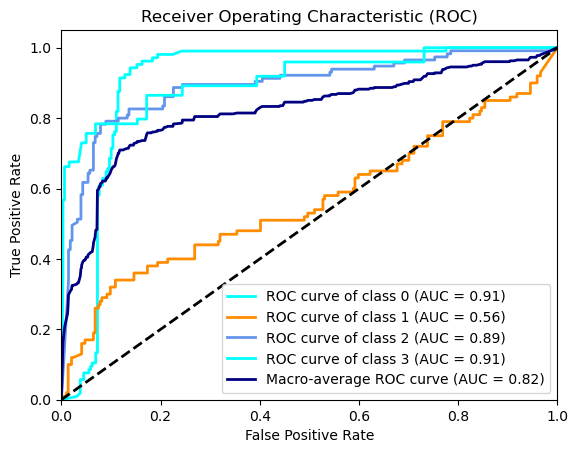

In [90]:
mlp = keras.models.load_model("my_little_perceptron.keras")
plot_roc_curve(mlp, df_testing, y_test_ohe)

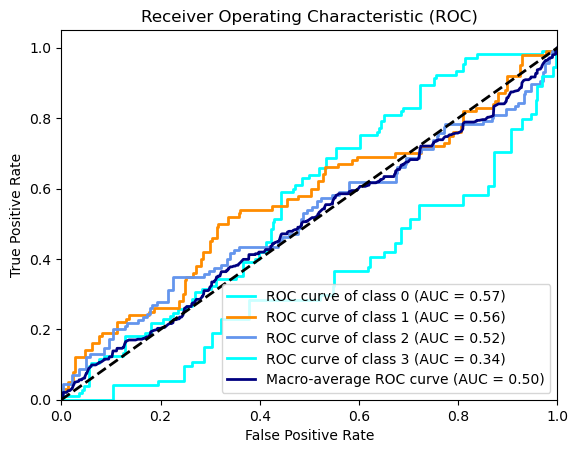

In [91]:
cnn = keras.models.load_model("CNN_2.keras")
plot_roc_curve(cnn, df_testing, y_test_ohe)

Based upon the AUC and ROC, we can clearly see that CNN 2 performs very poorly. In fact, it's about the same as randomly guessing, and even worse than randomly guessing for class 3! The Multi-Layer Perceptron blows the CNN out of the water in terms of ROC curves, in that we can see that the True Positive Rate is higher at a much earlier time for the MLP than the CNN. 

Furthermore, the ROC curve of the MLP model is mostly optimial, with a sharp increase in TPR before flattening out for all classes except 1. The ROC curve of our CNN model is terrible, with an almost even exchange between TPR and FPR, amd for one of the classes even performing well below the chance line. 

## Exceptional Work (1 points total)
Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance.

**The following cells of code was copied out of Dr. Larson's 'Lab 12' notebook on Convolutional Neural Networks, but fitted for our specific dataset.**

In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# manipulated from Keras Documentation
#  https://keras.io/applications/
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')
res_model.summary()

2023-05-02 20:27:02.403824: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-02 20:27:02.413328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-02 20:27:02.464446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2023-05-02 20:27:02.464492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-02 20:27:02.998162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-02 20:27:02.998225: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [67]:
# This method creates the data, whether training or testing, in the form we desire
# Reused code from Lab 2
#Resnet was being a Diva so we have to reload the data
def create_dataset_tf(img_folder):
    # Read through all files in "img_folder"
    img_data_array = []
    class_name = []
    
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            img = cv2.imread(os.path.join(img_folder,dir1,file))
            img = cv2.resize(img,(256, 256))
            img_normalized = cv2.normalize(img,None,0,1.0,
                                           cv2.NORM_MINMAX, 
                                           dtype=cv2.CV_32F)
            img_data_array.append([img_normalized])             #Image bracketed to ensure that each image shows one channel
            class_name.append(dir1)
    
    # return array with training data.
    img_data_array = np.array(img_data_array)
    class_name = np.array(class_name)
    return img_data_array, class_name

Predicted: [('n03196217', 'digital_clock', 0.3872239), ('n01930112', 'nematode', 0.054618884), ('n04286575', 'spotlight', 0.043755904), ('n09229709', 'bubble', 0.04201462), ('n03729826', 'matchstick', 0.038632188), ('n04328186', 'stopwatch', 0.027398787), ('n03544143', 'hourglass', 0.019478519), ('n02708093', 'analog_clock', 0.019277887), ('n06359193', 'web_site', 0.018275034), ('n03197337', 'digital_watch', 0.015868427)]


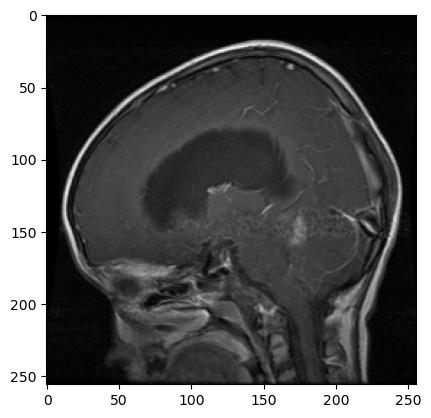

In [76]:
#Load the training and testing datasets
df_training, training_classes = create_dataset_tf("./Training")
df_testing, testing_classes = create_dataset_tf("./Testing")

################################################################
################################################################
################################################################
from skimage.transform import resize

#arbitrarily picked a number '57'
plt.imshow(df_training[57][0])

x = resize(X_train[57], (224,224,3),order=3)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)  

preds = res_model.predict(x)

print('Predicted:', decode_predictions(preds, top=10)[0])
################################################################
################################################################
################################################################

#Reshape the training and testing datasets
df_training = df_training.reshape((df_training.shape[0], 256, 256, 3))
df_testing = df_testing.reshape((df_testing.shape[0], 256, 256, 3))

#Change target classes to be integer so they can be used in OHE:
'glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'
for i in range(len(training_classes)):
    if training_classes[i] == 'glioma_tumor':
        training_classes[i] = int(1)
    elif training_classes[i] == 'meningioma_tumor':
        training_classes[i] = int(2)
    elif training_classes[i] == 'pituitary_tumor':
        training_classes[i] = int(3)
    else:
        training_classes[i] = int(0)

for i in range(len(testing_classes)):
    if testing_classes[i] == 'glioma_tumor':
        testing_classes[i] = int(1)
    elif testing_classes[i] == 'meningioma_tumor':
        testing_classes[i] = int(2)
    elif testing_classes[i] == 'pituitary_tumor':
        testing_classes[i] = int(3)
    else:
        testing_classes[i] = int(0)

In [77]:
X_train = df_training
X_test = df_testing
y_train = training_classes.astype(dtype='i')
y_test = testing_classes.astype(dtype='i')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1876, 256, 256, 3)
(1876,)
(394, 256, 256, 3)
(394,)


In [78]:
# connect new layers to the output
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)
x = X_train[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)   
%time preds = res_no_top.predict(x)
preds.shape

CPU times: user 54.8 ms, sys: 3.03 ms, total: 57.8 ms
Wall time: 53.2 ms


(1, 8, 8, 2048)

In [79]:
X_train_res = preprocess_input(X_train)
X_test_res = preprocess_input(X_test)

In [80]:
%%time

# train on half the data, to save a few hours
x_train_resnet = res_no_top.predict(X_train_res)
x_test_resnet = res_no_top.predict(X_test_res)
print(x_train_resnet.shape)

(1876, 8, 8, 2048)
CPU times: user 7.33 s, sys: 3.55 s, total: 10.9 s
Wall time: 8.25 s


In [81]:
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add, Flatten, Dense
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

resnet_transfer = Model(inputs=input_x, outputs=predictions)

resnet_transfer.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 8, 8, 2048)]      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               26214600  
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 804       
Total params: 26,215,404
Trainable params: 26,215,404
Non-trainable params: 0
_________________________________________________________________


In [83]:
y_train_ohe_resnet = y_train_ohe[:x_train_resnet.shape[0]]

resnet_transfer.compile(optimizer='rmsprop', 
              loss='mse',
              metrics=[tf.keras.metrics.Recall()])

resnet_history = resnet_transfer.fit(x_train_resnet,y_train_ohe_resnet,epochs=150,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

Epoch 1/150
30/30 [==============================] - 2s 30ms/step - loss: 0.3988 - recall_5: 0.2024 - val_loss: 0.3731 - val_recall_5: 0.2538
Epoch 2/150
30/30 [==============================] - 1s 18ms/step - loss: 0.3988 - recall_5: 0.2024 - val_loss: 0.3731 - val_recall_5: 0.2538
Epoch 3/150
30/30 [==============================] - 1s 18ms/step - loss: 0.3942 - recall_5: 0.2116 - val_loss: 0.3731 - val_recall_5: 0.2538
Epoch 4/150
30/30 [==============================] - 1s 18ms/step - loss: 0.4104 - recall_5: 0.1792 - val_loss: 0.3731 - val_recall_5: 0.2538
Epoch 5/150
30/30 [==============================] - 1s 18ms/step - loss: 0.3989 - recall_5: 0.2022 - val_loss: 0.3731 - val_recall_5: 0.2538
Epoch 6/150
30/30 [==============================] - 1s 18ms/step - loss: 0.4024 - recall_5: 0.1953 - val_loss: 0.3731 - val_recall_5: 0.2538
Epoch 7/150
30/30 [==============================] - 1s 18ms/step - loss: 0.3967 - recall_5: 0.2066 - val_loss: 0.3731 - val_recall_5: 0.2538
Epoch 

dict_keys(['loss', 'recall_5', 'val_loss', 'val_recall_5'])


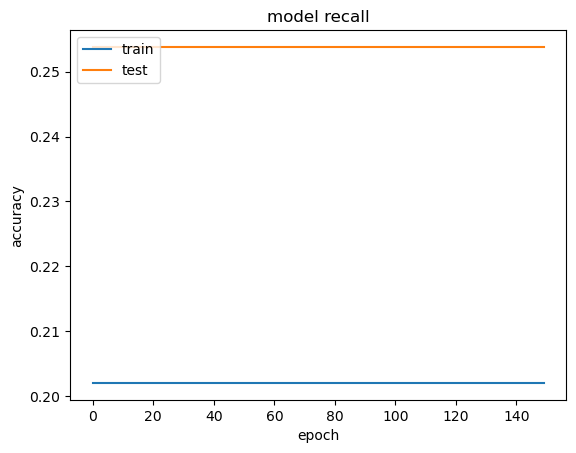

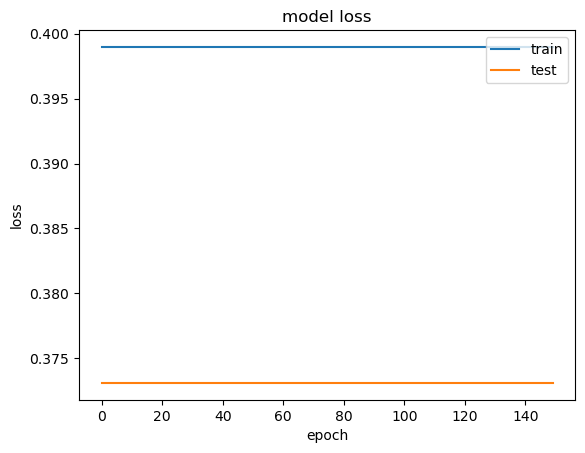

In [84]:
# list all data in history
print(resnet_history.history.keys())
# summarize history for accuracy
plt.plot(resnet_history.history['recall_5'])
plt.plot(resnet_history.history['val_recall_5'])
plt.title('model recall')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Gross! Freakin Idiot!

[![IMAGE_ALT](https://img.youtube.com/vi/SgrGLv1nMh8/0.jpg)](https://www.youtube.com/watch?v=SgrGLv1nMh8&t=3s)

*Click to see what I thought when I saw the Recall value of ResNet*

ResNet did NOT do very well, even compared to the best CNN we made. We got a foretaste of this disaster when we tried predicting an MRI. It detected various things at incredibly low confidences, with the highest confidence being a digital clock with 0.38 confidence. The model also failed to converge, unlike the models we made previously.

ResNet transfer learning failed to do better than CNN 2, which had an average recall of about 0.49. Even then, CNN 2 didn't do very well, as the recall rate was generally very poor.

The reason for ResNet's abysmal performance possibly has to do with the fact that brain scans were most likely not part of what ResNet was trained for. Based upon this, if someone wanted to use ResNet as part of a transfer learning model to classify brain tumors, it is recommended to add several more layers to get a better performance.